# ```deepchem```: Machine Learning models for Drug Discovery
#Tutorial 1: Basic Protein-Ligand Complex Featurized Models

Written by Evan Feinberg and Bharath Ramsundar

Copyright 2016, Stanford University

#Welcome to the ```deepchem``` tutorial. In this iPython Notebook, one can follow along with the code below to learn how to fit machine learning models with rich predictive power on chemical datasets.  

Overview:

In this tutorial, you will trace an arc from loading a raw dataset to fitting a cutting edge ML technique for predicting binding affinities. This will be accomplished by writing simple commands to access the deepchem Python API, encompassing the following broad steps:

1. Loading a chemical dataset, consisting of a series of protein-ligand complexes.
2. Featurizing each protein-ligand complexes with various featurization schemes. 
3. Fitting a series of models with these featurized protein-ligand complexes.
4. Visualizing the results.

First, let's point to a "dataset" file. This can come in the format of a CSV file or Pandas DataFrame. Regardless
of file format, it must be columnar data, where each row is a molecular system, and each column represents
a different piece of information about that system. For instance, in this example, every row reflects a 
protein-ligand complex, and the following columns are present: a unique complex identifier; the SMILES string
of the ligand; the binding affinity (Ki) of the ligand to the protein in the complex; a Python `list` of all lines
in a PDB file for the protein alone; and a Python `list` of all lines in a ligand file for the ligand alone.

This should become clearer with the example.


In [1]:
%autoreload 2
%pdb off
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_file= "../datasets/pdbbind_core_df.pkl.gz"
from deepchem.utils.save import load_from_disk
dataset = load_from_disk(dataset_file)

Let's see what `dataset` looks like:

In [3]:
print("Type of dataset is: %s" % str(type(dataset)))
print(dataset[:5])
print("Shape of dataset is: %s" % str(dataset.shape))

Type of dataset is: <class 'pandas.core.frame.DataFrame'>
  pdb_id                                             smiles  \
0   2d3u        CC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   
1   3cyx  CC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1CCCCC...   
2   3uo4        OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1   
3   1p1q                         CC1ONC(O)C1CC([NH3+])C(O)O   
4   3ag9  NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC[NH2...   

                                          complex_id  \
0    2d3uCC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O   
1  3cyxCC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1C...   
2    3uo4OC(O)C1CCC(NC2NCCC(NC3CCCCC3C3CCCCC3)N2)CC1   
3                     1p1qCC1ONC(O)C1CC([NH3+])C(O)O   
4  3ag9NC(O)C(CCC[NH2+]C([NH3+])[NH3+])NC(O)C(CCC...   

                                         protein_pdb  \
0  [HEADER    2D3U PROTEIN\n, COMPND    2D3U PROT...   
1  [HEADER    3CYX PROTEIN\n, COMPND    3CYX PROT...   
2  [HEADER    3UO4 PROTEIN\n, COMPND    3UO4 PROT...   
3 

One of the missions of ```deepchem``` is to form a synapse between the chemical and the algorithmic worlds: to be able to leverage the powerful and diverse array of tools available in Python to analyze molecules. This ethos applies to visual as much as quantitative examination:

In [4]:
import nglview
import tempfile
import os
import mdtraj as md
import numpy as np
import deepchem.utils.visualization
reload(deepchem.utils.visualization)
from deepchem.utils.visualization import combine_mdtraj, visualize_complex, convert_lines_to_mdtraj

first_protein, first_ligand = dataset.iloc[0]["protein_pdb"], dataset.iloc[0]["ligand_pdb"]

protein_mdtraj = convert_lines_to_mdtraj(first_protein)
ligand_mdtraj = convert_lines_to_mdtraj(first_ligand)
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)

In [5]:
def visualize_complex(complex_mdtraj):
  ligand_atoms = [a.index for a in complex_mdtraj.topology.atoms if "LIG" in str(a.residue)]
  binding_pocket_atoms = md.compute_neighbors(complex_mdtraj, 0.5, ligand_atoms)[0]
  binding_pocket_residues = list(set([complex_mdtraj.topology.atom(a).residue.resSeq for a in binding_pocket_atoms]))
  binding_pocket_residues = [str(r) for r in binding_pocket_residues]
  binding_pocket_residues = " or ".join(binding_pocket_residues)

  traj = nglview.MDTrajTrajectory( complex_mdtraj ) # load file from RCSB PDB
  ngltraj = nglview.NGLWidget( traj )
  ngltraj.representations = [
  { "type": "cartoon", "params": {
  "sele": "protein", "color": "residueindex"
  } },
  { "type": "licorice", "params": {
  "sele": "(not hydrogen) and (resi (%s))" %  binding_pocket_residues
  } },
  { "type": "ball+stick", "params": {
  "sele": "resn LIG"
  } }
  ]
  return ngltraj

In [6]:
ngltraj = visualize_complex(complex_mdtraj)
ngltraj

/home/enf/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:157: DeprecationWarning: Widget._keys_default is deprecated: use @default decorator instead.
  def _keys_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:157: DeprecationWarning: Widget._keys_default is deprecated: use @default decorator instead.
  def _keys_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecated: use @default decorator instead.
  def _kernel_default(self):
/home/enf/anaconda/li

Now that we're oriented, let's use ML to do some chemistry. 

So, step (2) will entail featurizing the dataset.

The available featurizations that come standard with deepchem are ECFP4 fingerprints, RDKit descriptors, NNScore-style bdescriptors, and hybrid binding pocket descriptors. Details can be found on ```deepchem.io```.

In [7]:
from deepchem.featurizers.fingerprints import CircularFingerprint
from deepchem.featurizers.basic import RDKitDescriptors
from deepchem.featurizers.nnscore import NNScoreComplexFeaturizer
from deepchem.featurizers.grid_featurizer import GridFeaturizer
grid_featurizer = GridFeaturizer(voxel_width=16.0, feature_types="voxel_combined", voxel_feature_types=["ecfp",
                                 "splif", "hbond", "pi_stack", "cation_pi", "salt_bridge"], ecfp_power=5, splif_power=5,
                                 parallel=True, flatten=True)
compound_featurizers = [CircularFingerprint(size=128)]
complex_featurizers = [grid_featurizer]

Note how we separate our featurizers into those that featurize individual chemical compounds, compound_featurizers, and those that featurize molecular complexes, complex_featurizers.

Now, let's perform the actual featurization. Calling ```featurizer.featurize()``` will return an instance of class ```FeaturizedSamples```. Internally, ```featurizer.featurize()``` (a) computes the user-specified features on the data, (b) transforms the inputs into X and y NumPy arrays suitable for ML algorithms, and (c) constructs a ```FeaturizedSamples()``` instance that has useful methods, such as an iterator, over the featurized data.

In [25]:
#Make a directory in which to store the featurized complexes.
import tempfile, shutil
base_dir = "./tutorial_output"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
data_dir = os.path.join(base_dir, "data")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
featurized_samples_file = os.path.join(data_dir, "featurized_samples.joblib")

feature_dir = os.path.join(base_dir, "features")
if not os.path.exists(feature_dir):
    os.makedirs(feature_dir)

samples_dir = os.path.join(base_dir, "samples")
if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)

train_dir = os.path.join(base_dir, "train")
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

valid_dir = os.path.join(base_dir, "valid")
if not os.path.exists(valid_dir):
    os.makedirs(valid_dir)

test_dir = os.path.join(base_dir, "test")
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

model_dir = os.path.join(base_dir, "model")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    

In [12]:
import deepchem.featurizers.featurize
reload(deepchem.featurizers.featurize)
from deepchem.featurizers.featurize import DataFeaturizer

In [17]:
featurizers = compound_featurizers + complex_featurizers
featurizer = DataFeaturizer(tasks=["label"],
                            smiles_field="smiles",
                            protein_pdb_field="protein_pdb",
                            ligand_pdb_field="ligand_pdb",
                            compound_featurizers=compound_featurizers,
                            complex_featurizers=[],
                            id_field="complex_id",
                            verbose=False)
from ipyparallel import Client
c = Client()
print("c.ids")
print(c.ids)
dview = c[:]
featurized_samples = featurizer.featurize(dataset_file, feature_dir, samples_dir,
                                          worker_pool=dview, shard_size=32)

from deepchem.utils.save import save_to_disk, load_from_disk

save_to_disk(featurized_samples, featurized_samples_file)

c.ids
[0, 1, 2, 3, 4, 5]


/home/enf/anaconda/lib/python2.7/site-packages/ipyparallel/client/client.py:306: DeprecationWarning: Client._profile_default is deprecated: use @default decorator instead.
  def _profile_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/ipyparallel/client/client.py:306: DeprecationWarning: Client._profile_default is deprecated: use @default decorator instead.
  def _profile_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/IPython/core/profiledir.py:57: DeprecationWarning: ProfileDir._location_changed is deprecated: use @observe and @unobserve instead.
  def _location_changed(self, name, old, new):
/home/enf/anaconda/lib/python2.7/site-packages/IPython/core/profiledir.py:126: DeprecationWarning: ProfileDir._security_dir_changed is deprecated: use @observe and @unobserve instead.
  def _security_dir_changed(self, name, old, new):
/home/enf/anaconda/lib/python2.7/site-packages/IPython/core/profiledir.py:71: DeprecationWarning: ProfileDir._log_dir_changed is deprec

In [21]:
featurized_samples = load_from_disk(featurized_samples_file)

Now, we conduct a train-test split. If you'd like, you can choose `splittype="scaffold"` instead to perform a train-test split based on Bemis-Murcko scaffolds.

In [26]:
splittype = "random"

train_samples, test_samples = featurized_samples.train_test_split(
    splittype, train_dir, test_dir, seed=2016)

/scratch/users/enf/deep-docking/deepchem/deepchem/featurizers/featurize.py:470: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return (shuffled[:train_cutoff], shuffled[train_cutoff:valid_cutoff],
/scratch/users/enf/deep-docking/deepchem/deepchem/featurizers/featurize.py:470: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return (shuffled[:train_cutoff], shuffled[train_cutoff:valid_cutoff],
/scratch/users/enf/deep-docking/deepchem/deepchem/featurizers/featurize.py:470: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return (shuffled[:train_cutoff], shuffled[train_cutoff:valid_cutoff],
/scratch/users/enf/deep-docking/deepchem/deepchem/featurizers/featurize.py:471: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  shuffled[valid_cutoff:])


We generate separate instances of the Dataset() object to hermetically seal the train dataset from the test dataset. This style lends itself easily to validation-set type hyperparameter searches, which we will illustate in a separate section of this tutorial. 

In [27]:
from deepchem.utils.dataset import Dataset

In [28]:
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=compound_featurizers, tasks=["label"])
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                       featurizers=compound_featurizers, tasks=["label"])

The performance of many ML algorithms hinges greatly on careful data preprocessing. Deepchem comes standard with a few options for such preprocessing.

In [29]:
input_transforms = ["normalize", "truncate"]
output_transforms = ["normalize"]
train_dataset.transform(input_transforms, output_transforms)
test_dataset.transform(input_transforms, output_transforms)

Now, we're ready to do some learning! To set up a model, we will need: (a) a dictionary ```task_types``` that maps a task, in this case ```label```, i.e. the Ki, to the type of the task, in this case ```regression```. For the multitask use case, one will have a series of keys, each of which is a different task (Ki, solubility, renal half-life, etc.) that maps to a different task type (regression or classification).

To fit a deepchem model, first we instantiate one of the provided (or user-written) model classes. In this case, we have a created a convenience class to wrap around any ML model available in Sci-Kit Learn that can in turn be used to interoperate with deepchem. To instantiate an ```SklearnModel```, you will need (a) task_types, (b) model_params, another ```dict``` as illustrated below, and (c) a ```model_instance``` defining the type of model you would like to fit, in this case a ```RandomForestRegressor```.

In [30]:
from sklearn.ensemble import RandomForestRegressor
from deepchem.models.standard import SklearnModel

In [31]:
task_types = {"label": "regression"}
model_params = {"data_shape": train_dataset.get_data_shape()}

model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor())
model.fit(train_dataset)
model_dir = tempfile.mkdtemp()
model.save(model_dir)

In [32]:
from deepchem.utils.evaluate import Evaluator
import pandas as pd

In [33]:
evaluator = Evaluator(model, train_dataset, verbose=True)
with tempfile.NamedTemporaryFile() as train_csv_out:
  with tempfile.NamedTemporaryFile() as train_stats_out:
    _, train_r2score = evaluator.compute_model_performance(
        train_csv_out, train_stats_out)

evaluator = Evaluator(model, test_dataset, verbose=True)
test_csv_out = tempfile.NamedTemporaryFile()
with tempfile.NamedTemporaryFile() as test_stats_out:
    _, test_r2score = evaluator.compute_model_performance(
        test_csv_out, test_stats_out)

print test_csv_out.name
train_test_performance = pd.concat([train_r2score, test_r2score])
train_test_performance["split"] = ["train", "test"]
train_test_performance

Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7f42c787d390>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7f42c787d540>
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7f42c787d4b0>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7f42c787d780>
/local-scratch/enf/7438120/tmp1Yjtiz


/home/enf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormatter._type_printers_default is deprecated: use @default decorator instead.
  def _type_printers_default(self):
/home/enf/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarni

,task_name,r2_score,rms_error,split
0,label,0.806727,0.988301,train
0,label,0.342652,1.805124,test


In this simple example, in few yet intuitive lines of code, we traced the machine learning arc from featurizing a raw dataset to fitting and evaluating a model. 

Here, we featurized only the ligand. The signal we observed in R^2 reflects the ability of circular fingerprints and random forests to learn general features that make ligands "drug-like."

Let's take a quick look at what the algorithm determines to be high- and low-affinity drugs.



In [39]:
predictions = pd.read_csv(test_csv_out.name)
print(predictions)
predictions = predictions.sort(['label'], ascending=[0])

    Unnamed: 0                                                ids     label  \
0            0    2d3uCC1CCCCC1S(O)(O)NC1CC(C2CCC(CN)CC2)SC1C(O)O  0.577883   
1            1  3cyxCC(C)(C)NC(O)C1CC2CCCCC2C[NH+]1CC(O)C(CC1C...  1.142494   
2           24                      2zxdCC(C)C1[NH2+]CC(O)C(O)C1O -0.310858   
3           25                     3bfu[NH3+]C(CC1NSNC1O)C([O-])O  0.238070   
4           28                                 3u9qCCCCCCCCCC(O)O -0.750001   
5           44              3l7bNC1CCN(C2OC(CO)C(O)C(F)C2O)C(O)N1 -1.785122   
6           45  3oztOC(NCCCC1OC(N2CCC(O)CC2)C(O)C1O)C1CC(N(O)O... -0.880698   
7           49  3ivgCOC1CCC2C(CC(CNS(O)(O)C3CC4CCCCC4O3)N2CC(O... -0.791824   
8           54  1sqa[NH3+]CC1CCC(NC(O)C2CC3CCC(C([NH3+])[NH3+]...  1.775069   
9           56                     2xdlCCN(CC)C(O)C1CCC(O)C(OC)C1 -1.419170   
10          57                      3udhOC1NC2CCCCC2C12CC[NH2+]C2 -1.549867   
11          73         1w4oOCC1OC(N2CCC(O)NC2O)C(O)C

In [40]:
top_ligand = predictions.iloc[0]['ids']
ligand1 = convert_lines_to_mdtraj(dataset.loc[dataset['complex_id']==top_ligand]['ligand_pdb'].values[0])

def visualize_ligand(ligand_mdtraj):
  traj = nglview.MDTrajTrajectory( ligand_mdtraj ) # load file from RCSB PDB
  ngltraj = nglview.NGLWidget( traj )
  ngltraj.representations = [
  { "type": "ball+stick", "params": {
  "sele": "all"
  } }
  ]
  return ngltraj

ngltraj = visualize_ligand(ligand1)
ngltraj

In [41]:
worst_ligand = predictions.iloc[predictions.shape[0]-2]['ids']
ligand1 = convert_lines_to_mdtraj(dataset.loc[dataset['complex_id']==worst_ligand]['ligand_pdb'].values[0])
ngltraj = visualize_ligand(ligand1)
ngltraj

# The protein-ligand complex view.

The preceding simple example, in few yet intuitive lines of code, traces the machine learning arc from featurizing a raw dataset to fitting and evaluating a model. 

In this next section, we illustrate ```deepchem```'s modularity, and thereby the ease with which one can explore different featurization schemes, different models, and combinations thereof, to achieve the best performance on a given dataset. We will demonstrate this by examining protein-ligand interactions. 

In the previous section, we featurized only the ligand. The signal we observed in R^2 reflects the ability of circular fingerprints and random forests to learn general features that make ligands "drug-like." However, the affinity of a drug for a target is determined not only by the drug itself, of course, but the way in which it interacts with a protein. 

In [42]:
train_dir, validation_dir, test_dir = tempfile.mkdtemp(), tempfile.mkdtemp(), tempfile.mkdtemp()
splittype="random"
train_samples, validation_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, validation_dir, test_dir, seed=2016)

task_types = {"label": "regression"}
performance = pd.DataFrame()
import deepchem.models.standard
from deepchem.models.standard import SklearnModel
from deepchem.utils.dataset import Dataset
from deepchem.utils.evaluate import Evaluator

n_trees_vals = [10, 20, 40, 80, 160]
for feature_type in (complex_featurizers + compound_featurizers):
    train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                        featurizers=[feature_type], tasks=["label"])
    validation_dataset = Dataset(data_dir=validation_dir, samples=validation_samples, 
                       featurizers=[feature_type], tasks=["label"])

    input_transforms = ["normalize", "truncate"]
    output_transforms = ["normalize"]
    train_dataset.transform(input_transforms, output_transforms)
    validation_dataset.transform(input_transforms, output_transforms)
    
    for n_trees in n_trees_vals:
        model_params = {"data_shape": train_dataset.get_data_shape()}

        model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor(n_estimators=n_trees))
        model.fit(train_dataset)
        model_dir = tempfile.mkdtemp()
        model.save(model_dir)


        evaluator = Evaluator(model, train_dataset, verbose=True)
        with tempfile.NamedTemporaryFile() as train_csv_out:
          with tempfile.NamedTemporaryFile() as train_stats_out:
            _, train_r2score = evaluator.compute_model_performance(
                train_csv_out, train_stats_out)

        evaluator = Evaluator(model, validation_dataset, verbose=True)
        with tempfile.NamedTemporaryFile() as validation_csv_out:
          with tempfile.NamedTemporaryFile() as validation_stats_out:
            _, validation_r2score = evaluator.compute_model_performance(
                validation_csv_out, validation_stats_out)

        train_valid_performance = pd.concat([train_r2score, validation_r2score])
        train_valid_performance["split"] = ["train", "validation"]
        train_valid_performance["featurizer"] = [str(feature_type.__class__), str(feature_type.__class__)]
        train_valid_performance["n_trees"] = [n_trees, n_trees]
        print(train_valid_performance)
        performance = pd.concat([performance, train_valid_performance])
performance

Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fea97ca6e40>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fea97ca6f60>
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fea994b8810>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fea994b8f60>
  task_name  r2_score  rms_error       split  \
0     label  0.850802   0.890800       train   
0     label  0.380784   1.172148  validation   

                                          featurizer  n_trees  
0  <class 'deepchem.featurizers.grid_featurizer.G...       10  
0  <class 'deepchem.featurizers.grid_featurizer.G...       10  
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fea994b8b70>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fea97ca6e40>
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fea97ca6f60>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fea994b8810>
  task_name

,task_name,r2_score,rms_error,split,featurizer,n_trees
0,label,0.850802,0.890800,train,<class 'deepchem.featurizers.grid_featurizer.G...,10
0,label,0.380784,1.172148,validation,<class 'deepchem.featurizers.grid_featurizer.G...,10
0,label,0.877179,0.808230,train,<class 'deepchem.featurizers.grid_featurizer.G...,20
0,label,0.157616,1.367150,validation,<class 'deepchem.featurizers.grid_featurizer.G...,20
0,label,0.900207,0.728532,train,<class 'deepchem.featurizers.grid_featurizer.G...,40
0,label,0.279117,1.264717,validation,<class 'deepchem.featurizers.grid_featurizer.G...,40
0,label,0.895135,0.746817,train,<class 'deepchem.featurizers.grid_featurizer.G...,80
0,label,0.303473,1.243169,validation,<class 'deepchem.featurizers.grid_featurizer.G...,80
0,label,0.904690,0.711980,train,<class 'deepchem.featurizers.grid_featurizer.G...,160
0,label,0.275001,1.268323,validation,<class 'deepchem.featurizers.grid_featurizer.G...,160


      r2_score
10   0.0457328
20    0.257332
40    0.251678
80    0.279337
160   0.278349
    ligand fingerprints complex features
10            0.0457328         0.380784
20             0.257332         0.157616
40             0.251678         0.279117
80             0.279337         0.303473
160            0.278349         0.275001


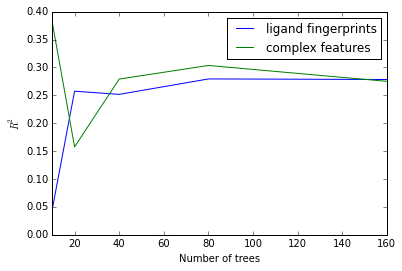

In [44]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(performance[['r2_score','split','featurizer']].values, index=performance['n_trees'].values, columns=['r2_score', 'split', 'featurizer'])
df = df.loc[df['split']=="validation"]
df = df.drop('split', 1)
fingerprint_df = df[df['featurizer'].str.contains('fingerprint')].drop('featurizer', 1)
print fingerprint_df
fingerprint_df.columns = ['ligand fingerprints']
grid_df = df[df['featurizer'].str.contains('grid')].drop('featurizer', 1)
grid_df.columns = ['complex features']
df = pd.concat([fingerprint_df, grid_df], axis=1)
print(df)

plt.clf()
df.plot()
plt.ylabel("$R^2$")
plt.xlabel("Number of trees")

In [63]:
train_dir, validation_dir, test_dir = tempfile.mkdtemp(), tempfile.mkdtemp(), tempfile.mkdtemp()
splittype="random"
train_samples, validation_samples, test_samples = featurized_samples.train_valid_test_split(
    splittype, train_dir, validation_dir, test_dir, seed=2016)

feature_type = complex_featurizers
train_dataset = Dataset(data_dir=train_dir, samples=train_samples, 
                    featurizers=feature_type, tasks=["label"])
validation_dataset = Dataset(data_dir=validation_dir, samples=validation_samples, 
                   featurizers=feature_type, tasks=["label"])
test_dataset = Dataset(data_dir=test_dir, samples=test_samples, 
                   featurizers=feature_type, tasks=["label"])

input_transforms = ["normalize", "truncate"]
output_transforms = ["normalize"]
train_dataset.transform(input_transforms, output_transforms)
validation_dataset.transform(input_transforms, output_transforms)
test_dataset.transform(input_transforms, output_transforms)

model_params = {"data_shape": train_dataset.get_data_shape()}

rf_model = SklearnModel(task_types, model_params, model_instance=RandomForestRegressor(n_estimators=20))
rf_model.fit(train_dataset)
model_dir = tempfile.mkdtemp()
rf_model.save(model_dir)


evaluator = Evaluator(rf_model, train_dataset, verbose=True)
with tempfile.NamedTemporaryFile() as train_csv_out:
  with tempfile.NamedTemporaryFile() as train_stats_out:
    _, train_r2score = evaluator.compute_model_performance(
        train_csv_out, train_stats_out)

evaluator = Evaluator(rf_model, test_dataset, verbose=True)
test_csv_out = tempfile.NamedTemporaryFile()
with tempfile.NamedTemporaryFile() as test_stats_out:
    predictions, test_r2score = evaluator.compute_model_performance(
        test_csv_out, test_stats_out)

train_test_performance = pd.concat([train_r2score, test_r2score])
train_test_performance["split"] = ["train", "test"]
train_test_performance["featurizer"] = [str(feature_type.__class__), str(feature_type.__class__)]
train_test_performance["n_trees"] = [n_trees, n_trees]
print(train_test_performance)

Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fea72843d20>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7feacef65300>
Saving predictions to <open file '<fdopen>', mode 'w+b' at 0x7fea79578270>
Saving model performance scores to <open file '<fdopen>', mode 'w+b' at 0x7fea994b8810>
  task_name  r2_score  rms_error  split     featurizer  n_trees
0     label  0.862417   0.855422  train  <type 'list'>      160
0     label  0.381613   1.323630   test  <type 'list'>      160


In [60]:
import deepchem.models.deep
reload(deepchem.models.deep)
from deepchem.models.deep import SingleTaskDNN
import numpy.random
from operator import mul
import itertools

model_params = {"activation": "relu",
                "momentum": .9,
                "batch_size": 64,
                "nb_epoch": 30,
                "data_shape": train_dataset.get_data_shape()}

lr_list = np.power(10., np.random.uniform(-3, -1, size=4))
decay_list = np.power(10., np.random.uniform(-6, -2, size=4))
nb_hidden_list = [10, 100, 1000]
nb_epoch_list = [5]
nesterov_list = [False]
dropout_list = [0.05, .1]
nb_layers_list = [2]
init_list = ["glorot_uniform"]
batchnorm_list = [True, False]
hyperparameters = [lr_list, decay_list, nb_hidden_list, nb_epoch_list,
                   nesterov_list, dropout_list, nb_layers_list,
                   init_list, batchnorm_list]
num_combinations = reduce(mul, [len(l) for l in hyperparameters])
best_validation_score = -np.inf
best_hyperparams = None
best_model, best_model_dir = None, None
performance_df = pd.DataFrame()
for ind, hyperparameter_tuple in enumerate(itertools.product(*hyperparameters)):
    print("Testing %s" % str(hyperparameter_tuple))
    print("Combo %d/%d" % (ind, num_combinations))
    (lr, decay, nb_hidden, nb_epoch, nesterov, dropout,
     nb_layers, init, batchnorm) = hyperparameter_tuple
    model_params["nb_hidden"] = nb_hidden
    model_params["decay"] = decay
    model_params["learning_rate"] = lr
    model_params["nb_epoch"] = nb_epoch
    model_params["nesterov"] = nesterov
    model_params["dropout"] = dropout
    model_params["nb_layers"] = nb_layers
    model_params["init"] = init
    model_params["batchnorm"] = batchnorm
    model_dir = tempfile.mkdtemp()
    model = SingleTaskDNN(task_types, model_params)
    model.fit(train_dataset)
    model.save(model_dir)
    
    evaluator = Evaluator(model, validation_dataset)
    valid_csv_out = tempfile.NamedTemporaryFile()
    valid_stats_out = tempfile.NamedTemporaryFile()
    df, r2score = evaluator.compute_model_performance(
        valid_csv_out, valid_stats_out)
    r2score["hyperparameters"] = str(hyperparameters)
    performance_df = pd.concat([performance_df, r2score])
    valid_r2_score = r2score.iloc[0]["r2_score"]
    print("learning_rate %f, nb_hidden %d, nb_epoch %d, nesterov %s, dropout %f => Validation set R^2 %f" %
          (lr, nb_hidden, nb_epoch, str(nesterov), dropout, valid_r2_score))
    if valid_r2_score > best_validation_score:
        best_validation_score = valid_r2_score
        best_hyperparams = hyperparameter_tuple
        if best_model_dir is not None:
            shutil.rmtree(best_model_dir)
        best_model_dir = model_dir
        best_model = model
    else:
        shutil.rmtree(model_dir)
    print("Best hyperparameters so-far: %s" % str(best_hyperparams))
    print("best_validation_score so-far: %f" % best_validation_score)

print("Best hyperparameters: %s" % str(best_hyperparams))
print("best_validation_score: %f" % best_validation_score)
best_dnn = best_model

Testing (0.0018171038259935624, 0.0049446750959222293, 10, 5, False, 0.05, 2, 'glorot_uniform', True)
Combo 0/192
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
learning_rate 0.001817, nb_hidden 10, nb_epoch 5, nesterov False, dropout 0.050000 => Validation set R^2 0.052310
Best hyperparameters so-far: (0.0018171038259935624, 0.0049446750959222293, 10, 5, False, 0.05, 2, 'glorot_uniform', True)
best_validation_score so-far: 0.052310
Testing (0.0018171038259935624, 0.0049446750959222293, 10, 5, False, 0.05, 2, 'glorot_uniform', False)
Combo 1/192
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
learning_rate 0.001817, nb_hidden 10, nb_epoch 5, nesterov False, dropout 0.050000 => Validation set R^2 0.236239
Best hyperparameters so-far: (0.0018171038259935624, 0.0049446750959222293, 10, 5, False, 0.05, 2, 'glorot_uniform', False)
best_validation_score so-far: 0.236239
Testing (0.0018171038259935624, 0.00494467509592

ids             3gnwCC1CCCC(C(O)N2C3CCCC(O)C3NC3CC(C)(C)CS(O)(...
label                                                     1.31713
label_pred                                                1.20469
label_weight                                                    1
y_means                                                     6.883
y_stds                                                     1.6832
Name: 155, dtype: object
DNN Test set R^2 0.442633


DNN Test set R^2 0.442633
RF Test set R^2 0.381613


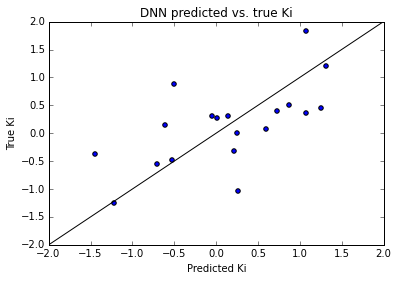

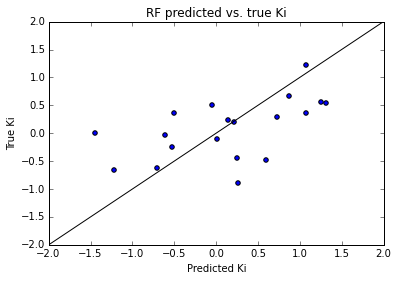

In [99]:
dnn_test_csv_out = tempfile.NamedTemporaryFile()
dnn_test_stats_out = tempfile.NamedTemporaryFile()
dnn_test_evaluator = Evaluator(best_dnn, test_dataset)
dnn_test_df, dnn_test_r2score = dnn_test_evaluator.compute_model_performance(
    dnn_test_csv_out, dnn_test_stats_out)
dnn_test_r2_score = dnn_test_r2score.iloc[0]["r2_score"]
print("DNN Test set R^2 %f" % (dnn_test_r2_score))

task = "label"
dnn_predicted_test = np.array(dnn_test_df[task + "_pred"])
dnn_true_test = np.array(dnn_test_df[task])

plt.clf()
plt.scatter(dnn_true_test, dnn_predicted_test)
plt.xlabel('Predicted Ki')
plt.ylabel('True Ki')
plt.title(r'DNN predicted vs. true Ki')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot([-3, 3], [-3, 3], marker=".", color='k')

rf_test_csv_out = tempfile.NamedTemporaryFile()
rf_test_stats_out = tempfile.NamedTemporaryFile()
rf_test_evaluator = Evaluator(rf_model, test_dataset)
rf_test_df, rf_test_r2score = rf_test_evaluator.compute_model_performance(
    rf_test_csv_out, rf_test_stats_out)
rf_test_r2_score = rf_test_r2score.iloc[0]["r2_score"]
print("RF Test set R^2 %f" % (rf_test_r2_score))
plt.show()

task = "label"
rf_predicted_test = np.array(rf_test_df[task + "_pred"])
rf_true_test = np.array(rf_test_df[task])
plt.scatter(rf_true_test, rf_predicted_test)
plt.xlabel('Predicted Ki')
plt.ylabel('True Ki')
plt.title(r'RF predicted vs. true Ki')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.plot([-3, 3], [-3, 3], marker=".", color='k')
plt.show()


In [101]:
predictions = dnn_test_df.sort(['label'], ascending=[0])

In [102]:
top_complex = predictions.iloc[0]['ids']
best_complex = dataset.loc[dataset['complex_id']==top_complex]

protein_mdtraj = convert_lines_to_mdtraj(best_complex["protein_pdb"].values[0])
ligand_mdtraj = convert_lines_to_mdtraj(best_complex["ligand_pdb"].values[0])
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)
ngltraj = visualize_complex(complex_mdtraj)
ngltraj

In [103]:
top_complex = predictions.iloc[1]['ids']
best_complex = dataset.loc[dataset['complex_id']==top_complex]

protein_mdtraj = convert_lines_to_mdtraj(best_complex["protein_pdb"].values[0])
ligand_mdtraj = convert_lines_to_mdtraj(best_complex["ligand_pdb"].values[0])
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)
ngltraj = visualize_complex(complex_mdtraj)
ngltraj

In [104]:
top_complex = predictions.iloc[predictions.shape[0]-1]['ids']
best_complex = dataset.loc[dataset['complex_id']==top_complex]

protein_mdtraj = convert_lines_to_mdtraj(best_complex["protein_pdb"].values[0])
ligand_mdtraj = convert_lines_to_mdtraj(best_complex["ligand_pdb"].values[0])
complex_mdtraj = combine_mdtraj(protein_mdtraj, ligand_mdtraj)
ngltraj = visualize_complex(complex_mdtraj)
ngltraj